**Project Introduction**

In this project, I will train an image classifier to recognize different species of flowers. I will be using the [University of Oxford Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/) 102 category dataset, consisting of 102 flower categories. The flowers chosen to be flowers commonly occuring in the United Kingdom. Each class consists of between 40 and 258 images. The details of the categories and the number of images for each class can be found on this [category statistics page](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html).

The images have large scale, pose and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on the dataset
* Use the trained classifier to predict image content


In [1]:
%matplotlib inline

import json
from datetime import date
from collections import OrderedDict

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torch import optim, nn
from torchvision import datasets, transforms, models
import torch.nn.functional as F

from PIL import Image

import os

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device= 'cpu'
print(device)

cuda:0


In [6]:
# print(os.listdir("../input/flower-102diffspecies-dataset/flower_data/flower_data"))
# print(os.listdir("../input/flowerjsonmap"))
# print(os.listdir("../input"))

In [7]:
"""Constants"""
ARCHITECTURE = 'vgg11'
AVAILABLE_MODELS = ['vgg11', 'vgg13', 'vgg16', 'vgg19', 'alexnet']
EPOCHS = 15
PRINT_EVERY = 20
BATCH_SIZE = 64
LOSS_RATE = 0.001
MEANS = [0.485, 0.456, 0.406]
STANDARD_DEVIATIONS = [0.229, 0.224, 0.225]
CROP_DIMENSION = 224
RESIZE_DIMENSION = 256

In [8]:
"""Method Playground"""
def get_dictionary_key(dictionary, value):
    """Return the dictionary key for the requested value.

    :param dictionary: the source dictionary
    :param value:(str) the requested value
    :return:
    """
    return {val: key for key, val in dictionary.items()}[value]


def displayImage(image, image_name=None, normalize=True):
    """

    :param image:
    :param normalize:
    :return:
    """
    forDisplay = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array(MEANS)
        standard_deviation = np.array(STANDARD_DEVIATIONS)
        forDisplay = standard_deviation * forDisplay + mean
        forDisplay = np.clip(forDisplay, 0, 1)
    
    fig, ax = plt.subplots()
    ax.imshow(forDisplay)
    ax.set_axis_off()
    
    if image_name:
        ax.set_title(image_name)
        
    plt.show()
    
def plot_flowers(tensor, tensor_class_idx, count=1, normalize=True):
    
    images, labels = next(tensor)
    a = np.floor(count**0.5).astype(int)
    b = np.ceil(1.*count/a).astype(int)
    fig = plt.figure(figsize=(3.*b,3.*a))
    for i in range(1,count+1):
        ax = fig.add_subplot(a,b,i)
        ax.plot([1,2,3],[1,2,3])
        forDisplay = images[i].numpy().transpose((1, 2, 0))

        if normalize:
            mean = np.array(MEANS)
            standard_deviation = np.array(STANDARD_DEVIATIONS)
            forDisplay = standard_deviation * forDisplay + mean
            forDisplay = np.clip(forDisplay, 0, 1)
        ax.imshow(forDisplay)
        ax.set_title(cat_to_name.get(get_dictionary_key(tensor_class_idx, labels[i].item())))
        ax.set_axis_off()
    #fig.suptitle("%d Flowers" % count, fontsize=16)
    
    plt.show()
    
def display_image_label(tensor, tensor_class_idx, count=1):
    """

    :param tensor:
    :param tensor_class_idx:
    :param count:
    :return:
    """
    images, labels = next(tensor)
    for i in range(count):
        displayImage(images[i], cat_to_name.get(get_dictionary_key(tensor_class_idx, labels[i].item())))

**Load the data**

I will use torchvision to load the data.
The dataset is split into two parts, training and validation. For the training, I will apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I will also make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this I will not perform any scaling or rotation transformations, but will resize then crop the images to the appropriate size.

The pre-trained networks I will use were trained on the ImageNet dataset where each color channel was normalized separately. For both sets I will normalize the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [1]:
data_dir = 'Datasets/flowers/flower_data'
json_file = 'Datasets/flowers/flower_data/cat_name.json'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [2]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(CROP_DIMENSION),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(MEANS, STANDARD_DEVIATIONS)
                                      ])

valid_transforms = transforms.Compose([transforms.Resize(RESIZE_DIMENSION), 
                                      transforms.CenterCrop(CROP_DIMENSION), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize(MEANS, STANDARD_DEVIATIONS)
                                     ])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE)

dataloaders = {
    "train": train_loader,
    "validation": valid_loader
}

NameError: name 'transforms' is not defined

In [11]:
# Get names of the classes within each dataset
train_class_idx = train_dataset.class_to_idx
valid_class_idx = valid_dataset.class_to_idx

**Label mapping**

I will need to load in a mapping from category label to category name. I found this in the file cat_to_name.json in the dataset flower-json-map. I will read in the JSON object with the json module. This will provide a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [12]:
cat_to_name = dict()

with open("Datasets/flowers/flower_data/cat_name.json") as f:
    jdata = json.load(f)
    for row in jdata:
        keys = ['FIELD2','FIELD5','FIELD8']
        values = ['FIELD3','FIELD6','FIELD9']
        key = ''
        val = ''
        for k in keys:
            if k in row.keys():
                key = k
                break
        for v in values:
            if v in row.keys():
                val = v
                break
        cat_to_name[row[val]] = row[key]
print(cat_to_name)
len(cat_to_name)

{43: 'alpine sea holly', 71: 'pelargonium', 40: 'moon orchid', 105: 'anthurium', 102: 'californian poppy', 162: 'foxglove', 78: 'gazania', 91: 'fritillary', 166: 'frangipani', 96: 'azalea', 82: 'mexican petunia', 46: 'monkshood', 45: 'tiger lily', 49: 'yellow iris', 108: 'cape flower', 67: 'orange dahlia', 127: 'barbeton daisy', 52: 'silverbush', 54: 'windflower', 50: 'cautleya spicata', 114: 'geranium', 66: 'mallow', 112: 'clematis', 56: 'sweet pea', 85: 'wild pansy', 87: 'snapdragon', 109: 'pink-yellow dahlia?', 86: 'columbine', 41: 'siam tulip', 92: 'common dandelion', 48: 'spear thistle', 154: 'cyclamen', 60: 'hard-leaved pocket orchid', 59: 'pincushion flower', 131: 'hibiscus', 128: 'bougainvillea', 63: 'magnolia', 76: 'hippeastrum', 65: 'english marigold', 55: 'japanese anemone', 258: 'petunia', 61: 'osteospermum', 137: 'lotus', 130: 'sword lily', 93: 'primula', 120: 'thorn apple', 58: 'trumpet creeper', 42: 'spring crocus', 62: 'tree poppy', 171: 'rose', 107: 'morning glory', 75

56

**Flower viewing**

I will take this opportunity to preview images from both the training image set and the validation image set.

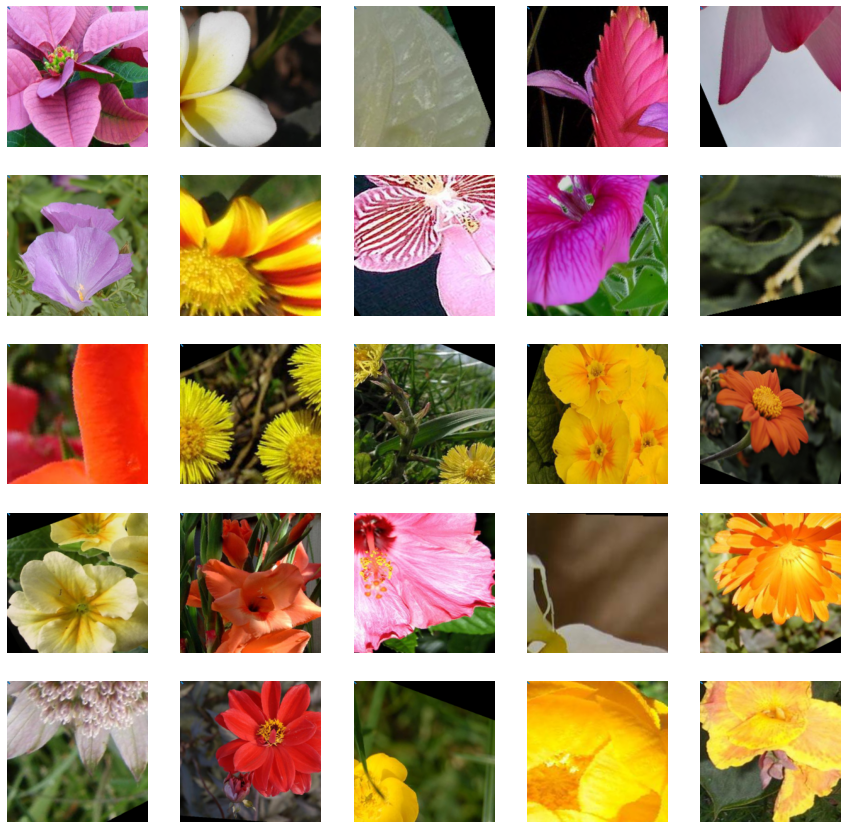

In [13]:
plot_flowers(iter(train_loader), train_class_idx, 25)

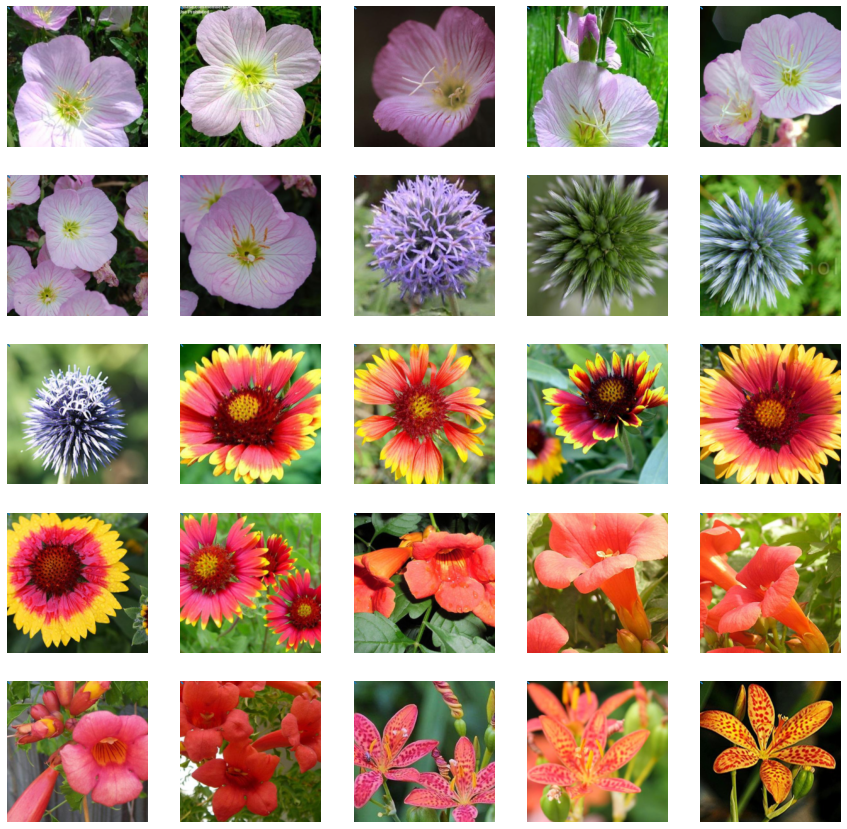

In [14]:
plot_flowers(iter(valid_loader), valid_class_idx, 25)

**Building and training the classifier**

Now that the data is ready, it's time to build and train the classifier. I will choose from the pretrained models in torchvision.models to get the image features. I will then build and train a new feed-forward classifier using those features.

The process will be broken down into multiple steps:

* Load a pre-trained network
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training I will be updating only the weights of the feed-forward network.



In [25]:
# Set the pretrained model
if ARCHITECTURE in AVAILABLE_MODELS:
    neural_network_model = getattr(models, ARCHITECTURE)(pretrained=True)
    if ARCHITECTURE == 'alexnet':
        current_in_features = neural_network_model.classifier._modules['1'].in_features
    else:
        current_in_features = neural_network_model.classifier._modules['0'].in_features
else:
    # Raise exception if architecture doesn't match available models
    raise Exception("Requested pretrained model unavailable for selection")

# Freeze parameters so we don't backpropagate through them
for param in neural_network_model.parameters():
    param.requires_grad = False
    
# Set the additional layers
neural_network_classifier = nn.Sequential(OrderedDict([
                          ('fc1',nn.Linear(current_in_features,512)),
                          ('dropout',nn.Dropout(p = 0.1)),    
                          ('relu',nn.ReLU()),
                          ('fc2',nn.Linear(512,256)),
                          ('dropout2',nn.Dropout(p = 0.1)),
                          ('relu2',nn.ReLU()),
                          ('fc3',nn.Linear(256,128)),
                          ('dropout3',nn.Dropout(p = 0.1)),
                          ('relu3',nn.ReLU()),
                          ('outputs',nn.Linear(128,102)),
                          ('logsoftmax',nn.LogSoftmax(dim = 1))
                          ]))

# Set the new classifier
neural_network_model.classifier = neural_network_classifier
neural_network_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [26]:
print("Training on %s" % device)
print("%s batchs of %s images per batch" % (len(train_loader.batch_sampler), train_loader.batch_size))
print("Average loss and accuracy will display every %s batches" % PRINT_EVERY)
train_losses, validation_losses, validation_accuracy = [], [], []

Training on cuda:0
103 batchs of 64 images per batch
Average loss and accuracy will display every 20 batches


In [27]:
# Train neural network model
def train_neural_network(model, training_dataset, validation_dataset, 
                         epochs, print_every, criterion, optimizer, device):
    """
    
    :param model: 
    :param dataset: 
    :param epochs: 
    :param print_every: 
    :param criterion: 
    :param optimizer: 
    :param device: 
    :return: 
    """
    # Set model to appropriate device
    model.to(device)
    #print(model)
    batch_size = training_dataset.batch_size
    # Print training overview messages
    print("Training on %s" % device)
    print("%s batchs of %s images per batch" % (len(training_dataset.batch_sampler) * epochs, batch_size))
    print("Average loss and accuracy will display every %s batches\n" % print_every)
    
    current_iteration = 0
    
    for epoch in range(epochs):
        epoch_loss = 0
        model.train()
        print("Working on Epoch: %s/%s" % (epoch+1, epochs))
        print("---------------------------------------")
        
        for ii, (inputs, labels) in enumerate(training_dataset):
            current_iteration += 1
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Set all optimizer gradients to zero
            optimizer.zero_grad()
            
            # Forward and backward passes
            outputs = model.forward(inputs)
#             print(outputs.size(), F.one_hot(labels, num_classes=102).size())
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            
            # Update loss for current epoch
            epoch_loss += loss.item()
            
            # Display Average Loss and Accuracy if needed
            if current_iteration % print_every == 0:
                print("---------------------------------------")
                print("Current status Batch %s: Images %s to %s." % (current_iteration, batch_size * 
                                                                      current_iteration, batch_size *
                                                                      (current_iteration + 1)))
                validation_correct, validation_total, validation_loss = check_neural_network_accuracy(model, 
                                                                                                      validation_dataset,
                                                                                                      device, criterion)
                train_losses.append(epoch_loss / print_every)
                validation_losses.append(validation_loss / print_every)
                validation_accuracy.append((validation_correct / validation_total) * 100)
                print("Training Loss: {:.3f}".format(epoch_loss / print_every),
                      " - Validation Loss: {:.3f}".format(validation_loss / print_every),
                      " - Validation Accuracy: %d%%" % ((validation_correct / validation_total) * 100))
                epoch_loss = 0
                
                
def check_neural_network_accuracy(model, dataset, device, criterion, correct=0, total=0):    
    print("Checking accuracy:")
    loss = 0
    model.to(device)
    model.eval()
    
    # Check accuracy without calculating gradient
    with torch.no_grad():
        for ii, (inputs, labels) in enumerate(dataset):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            current_loss = criterion(outputs, labels)
            # Update loss for current training
            loss += current_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    model.train()
    
    return correct, total, loss

**Adam optimization over Stochastic Gradient Descent**

I must admit I am still learning the situations where SGD will outperform using an optimizer like Adam but for this project I felt it performed well. The beauty of multivariable calculus is the ability to approach continuous functions in unwieldy dimensions with tools and techniques to wrestle the functions into forms that provide a fighting chance. Why fight a monster in 6 dimensions when you could shadow box with it in 3 dimensions using a bit of partial derivative magic? This is why Adam seems an interesting choice for deep learning neural networks. 

If we are to imagine a highly complex set of weights and biases simplified to a bounded linear problem of balancing mass. We can use Adam to dynamically calculate the moments needed to find center of mass along the surface and adjust our model accordingly.


In [28]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(neural_network_model.classifier.parameters(), lr=LOSS_RATE)

In [29]:
# device = 'cpu'
train_neural_network(neural_network_model, train_loader, valid_loader, EPOCHS, PRINT_EVERY, criterion, optimizer, device)

Training on cuda:0
1545 batchs of 64 images per batch
Average loss and accuracy will display every 20 batches

Working on Epoch: 1/15
---------------------------------------
---------------------------------------
Current status Batch 20: Images 1280 to 1344.
Checking accuracy:
Training Loss: 4.463  - Validation Loss: 2.587  - Validation Accuracy: 15%
---------------------------------------
Current status Batch 40: Images 2560 to 2624.
Checking accuracy:
Training Loss: 3.908  - Validation Loss: 2.031  - Validation Accuracy: 29%
---------------------------------------
Current status Batch 60: Images 3840 to 3904.
Checking accuracy:
Training Loss: 3.111  - Validation Loss: 1.574  - Validation Accuracy: 41%
---------------------------------------
Current status Batch 80: Images 5120 to 5184.
Checking accuracy:
Training Loss: 2.621  - Validation Loss: 1.231  - Validation Accuracy: 50%
---------------------------------------
Current status Batch 100: Images 6400 to 6464.
Checking accuracy:


Training Loss: 0.634  - Validation Loss: 0.304  - Validation Accuracy: 88%
---------------------------------------
Current status Batch 860: Images 55040 to 55104.
Checking accuracy:
Training Loss: 0.835  - Validation Loss: 0.298  - Validation Accuracy: 88%
---------------------------------------
Current status Batch 880: Images 56320 to 56384.
Checking accuracy:
Training Loss: 0.783  - Validation Loss: 0.282  - Validation Accuracy: 89%
---------------------------------------
Current status Batch 900: Images 57600 to 57664.
Checking accuracy:
Training Loss: 0.784  - Validation Loss: 0.299  - Validation Accuracy: 89%
---------------------------------------
Current status Batch 920: Images 58880 to 58944.
Checking accuracy:
Training Loss: 0.775  - Validation Loss: 0.276  - Validation Accuracy: 89%
Working on Epoch: 10/15
---------------------------------------
---------------------------------------
Current status Batch 940: Images 60160 to 60224.
Checking accuracy:
Training Loss: 0.492 

**Review loss and accuracy**

I will plot the loss during training and validation to check for overfitting. I will also plot accuracy during the validation process.

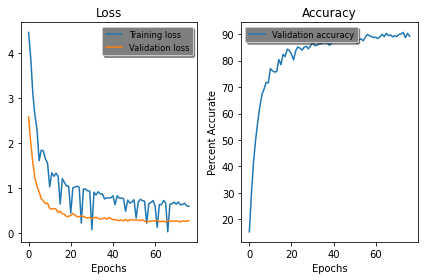

In [30]:
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
legend = plt.legend(loc='upper right', shadow=True, fontsize='small')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C7')

plt.subplot(1, 2, 2)
plt.plot(validation_accuracy, label='Validation accuracy')
plt.title('Accuracy')
plt.ylabel('Percent Accurate')
plt.xlabel('Epochs')
legend = plt.legend(loc='upper left', shadow=True, fontsize='small')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C7')
plt.tight_layout()


In [ ]:
def size_image(image):
    width, height = image.size
    
    return width, height;

def create_thumbnail(image, width, height, short_side):
    if width < height:
        return short_side, height;
    else:
        return width, short_side;
    
def test_process(image):
    normalize = transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
        )
    preprocess = transforms.Compose([transforms.Resize(256), 
                                      transforms.CenterCrop(224), 
                                      transforms.ToTensor(), 
                                      normalize,
                                     ])
   
    img_pil = Image.open(image)
    print(img_pil)
    img_tensor = preprocess(img_pil)
    print(img_tensor.size())
    img_np = img_tensor.numpy()
    print(img_np.shape)
    #img_tensor.unsqueeze_(0)
    return img_np
    
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array'''
    
    process_transforms = transforms.Compose([transforms.Resize(RESIZE_DIMENSION),
                                             transforms.CenterCrop(CROP_DIMENSION),
                                             transforms.ToTensor(),
                                             transforms.Normalize(MEANS, STANDARD_DEVIATIONS),
                                            ])
    
    pil_image = Image.open(image)
    tensor_image = process_transforms(pil_image)
    numpy_image = tensor_image.numpy()
    
    return numpy_image

In [ ]:
horizontal_image = process_image(valid_dir + '/46/image_01034.jpg')
vertical_image = process_image(valid_dir + '/22/image_05361.jpg')

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    if title is not None:
        ax.set_title(title)
    ax.axis('off')    
    ax.imshow(image)
    
    return ax

In [ ]:
imshow(horizontal_image)
imshow(vertical_image)

In [ ]:
def process_image_tensor(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array'''
    
    process_transforms = transforms.Compose([transforms.Resize(RESIZE_DIMENSION),
                                             transforms.CenterCrop(CROP_DIMENSION),
                                             transforms.ToTensor(),
                                             transforms.Normalize(MEANS, STANDARD_DEVIATIONS),
                                            ])
    
    pil_image = Image.open(image_path)
    tensor_image = process_transforms(pil_image)
    
    return tensor_image

def convert_labels(labels, class_idx):
    
    names_array = np.array([])
    #print(classes_array[0])
    for i in np.nditer(labels.cpu().numpy()):
        #print(i.item())
        names_array = np.append(names_array, 
                                cat_to_name.get(get_dictionary_key(class_idx, i.item())))
    return names_array

def predict(image_path, model, class_idx, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.to(device)
    model.eval()
    image_tensor = process_image_tensor(image_path).unsqueeze_(0)
    #image_tensor = image_tensor.cuda()
    #model.to(check_gpu())
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = model.forward(image_tensor)
    
    probabilities = torch.exp(output)
    probs, labels = probabilities.topk(topk)
    
    #print(probs)
    #print(labels)
    #Convert labels to numpy array of names
    
    #print("Labels:%s" %labels)
    #names = list(cat_to_name.values())
    #tests = [names[x] for x in labels[0]]
    return probs.cpu().numpy()[0], convert_labels(labels, class_idx);
    
#print(predict(valid_dir + '/46/image_01034.jpg', neural_network_model))

In [ ]:
def get_category_num(image_path):
    return image_path.split('/')[-2]

def get_dataset_subtype(image_path):
    return image_path.split('/')[-3]

def get_class_idx(image_path):
    return dataset_info[get_dataset_subtype(image_path)]['class_idx']

# Display an image along with the top 5 classes
def view_class_probability(image_path, neural_network_model, class_idx):
    probabilities, classes = predict(image_path, neural_network_model, class_idx)
    
    
    image_elements = image_path.split('/')    
    flower_category_num = image_elements[-2]
    class_type = image_elements[-3]
    #print(dataset_info[class_type]['class_idx'])
    
    fig, (ax1, ax2) = plt.subplots(figsize = (6,10), ncols=2)
    ax1 = plt.subplot(2,1,1)
    imshow(process_image(image_path), ax1)
    
    
    
    # Set up title
    title = cat_to_name.get(str(flower_category_num))
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax1, title);
    ax2 = fig.add_subplot(2,1,2)
    y_pos = np.arange(len(classes))
    #print(probabilities)
    '''performance = np.around(probabilities, decimals = 3)'''
    
    #print(performance)
    error = np.random.rand(len(classes))

    ax2.barh(y_pos, probabilities, align='center',
        color='blue')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(classes)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_xlabel('Probability')
    ax2.set_title('Class Probability')
    plt.tight_layout()

**Class Prediction**

Once independent images are placed in the correct format, I will be making predictions with my neural network model. A common practice is to predict the top 5 or so (usually called top- K ) most probable classes. I will calculate the class probabilities then find the  K  largest values.

I will then use matplotlib to plot the probabilities for the top 5 classes as a bar graph, along with the input image.

In [ ]:
vertical_image_path = valid_dir + '/22/image_05361.jpg'
view_class_probability(vertical_image_path, neural_network_model, valid_class_idx)

In [ ]:
horizontal_image_path = valid_dir + '/46/image_01034.jpg'
view_class_probability(horizontal_image_path, neural_network_model, valid_class_idx)